In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Reshape, LSTM
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-02-28 14:53:56.472966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        features = 48           # Change this value to features you have in your dataset.
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(256, activation='relu')
        # self.dense2 = Dense(256, activation='relu')
        self.dense3 = Dense(512, activation='relu')
        # self.lstm1 = LSTM(512, activation='tanh', return_sequences=True)
        self.lstm1 = LSTM(256, activation='tanh', return_sequences=True)
        self.lstm2 = LSTM(128, activation='tanh', return_sequences=False)
        self.output_layer = Dense(features, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = Reshape((1, -1))(x) # Add a time dimension to the data
        x = self.lstm1(x)
        x = self.lstm2(x)
        return self.output_layer(x)

In [3]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dense1 = Dense(512, activation='relu')
        # self.dense2 = Dense(256, activation='relu')
        self.dense2 = Dense(256, activation='relu')
        self.dense3 = Dense(128, activation='relu')
        # self.lstm1 = LSTM(512, activation='tanh', return_sequences=True)
        self.lstm1 = LSTM(256, activation='tanh', return_sequences=True)
        self.lstm2 = LSTM(128, activation='tanh', return_sequences=False)
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = Reshape((1, -1))(inputs) # Add a time dimension to the data
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)

In [4]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples) # Generate random latent points
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples) # Generate random latent points
    X = generator.predict(x_input) # Generate fake data
    y = np.zeros((n_samples, 1)) # Set target labels to 0 (fake)
    return X, y


def train_gan(x, y, generator, discriminator, gan, latent_dim, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    history = {"d_loss": [], "g_loss": []}
    for i in range(n_epochs):
        X_real, y_real = x, y
        d_loss_real = discriminator.train_on_batch(X_real, y_real)

        X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        d_loss_fake = discriminator.train_on_batch(X_fake, y_fake)

        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        g_loss = gan.train_on_batch(X_gan, y_gan)

        history["d_loss"].append(0.5 * np.add(d_loss_real, d_loss_fake))
        history["g_loss"].append(g_loss)

        if (i+1) % 2 == 0:
            print(f"Epoch {i+1}, d_loss={history['d_loss'][-1]}, g_loss={history['g_loss'][-1]}")

    return history

In [5]:
latent_dim = 150

generator = Generator()
discriminator = Discriminator()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
loss_fn = tf.keras.losses.BinaryCrossentropy()

generator.compile(optimizer=optimizer, loss=loss_fn)
discriminator.compile(optimizer=optimizer, loss=loss_fn)

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer=optimizer, loss=loss_fn)

2023-02-28 14:54:01.954405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
dataset = pd.read_csv('processed_diabetic_data.csv')

In [7]:
X_real = dataset.iloc[1:1001,2:]

In [8]:
N_Samples = 1000 # This variable indicates that how many samples you want to take from the training set for training your model.

y_real = np.ones((N_Samples, 1))
X_real = dataset.iloc[:N_Samples,2:]
X_real = X_real.astype(np.float)

/tmp/ipykernel_13663/1490412855.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_real = X_real.astype(np.float)


In [9]:
history = train_gan(X_real, y_real, generator, discriminator, gan, latent_dim, n_epochs=100, n_batch=64)

1/1 [==============================] - 0s 43ms/step
Epoch 2, d_loss=0.6821524500846863, g_loss=0.6893658638000488
1/1 [==============================] - 0s 36ms/step
Epoch 4, d_loss=0.661081850528717, g_loss=0.6840506792068481
1/1 [==============================] - 0s 37ms/step
Epoch 6, d_loss=0.6339785754680634, g_loss=0.6775411367416382
1/1 [==============================] - 0s 40ms/step
Epoch 8, d_loss=0.5970075726509094, g_loss=0.6685284972190857
1/1 [==============================] - 0s 37ms/step
Epoch 10, d_loss=0.5497021526098251, g_loss=0.6559270620346069
1/1 [==============================] - 0s 36ms/step
Epoch 12, d_loss=0.49628835916519165, g_loss=0.6404893398284912
1/1 [==============================] - 0s 39ms/step
Epoch 14, d_loss=0.4489283561706543, g_loss=0.6240153312683105
1/1 [==============================] - 0s 28ms/step
Epoch 16, d_loss=0.4205682072788477, g_loss=0.6099356412887573
1/1 [==============================] - 0s 35ms/step
Epoch 18, d_loss=0.4092495068907

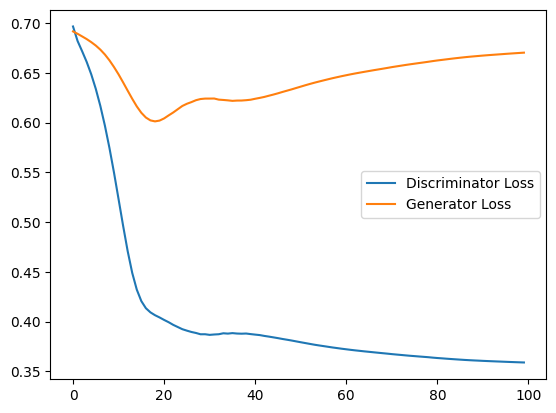

In [10]:
plt.plot(history["d_loss"], label="Discriminator Loss")
plt.plot(history["g_loss"], label="Generator Loss")
plt.legend()
plt.show()

In [11]:
n_samples = 1000    # this variavle means how many samples you want to generate.

# latent factor is a hyperperameter typically its value is between 50 to 200.

synthetic_data = generator.predict(generate_latent_points(latent_dim, n_samples))


32/32 [==============================] - 2s 8ms/step


In [12]:
synthetic_data = pd.DataFrame(synthetic_data, columns=list(X_real.columns))

In [13]:
X_real['age']

0       0.0
1      10.0
2      20.0
3      30.0
4      40.0
       ... 
995    70.0
996     0.0
997    60.0
998    70.0
999    50.0
Name: age, Length: 1000, dtype: float64

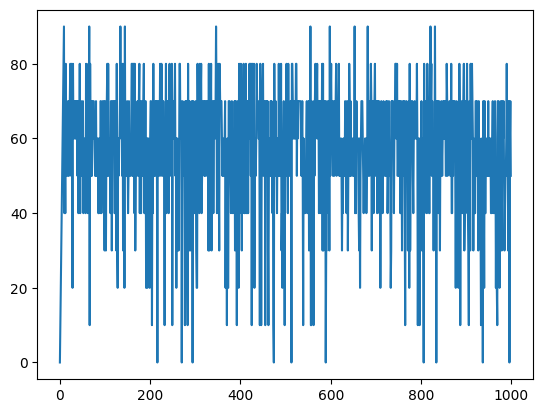

In [14]:
plt.plot(X_real['age'])

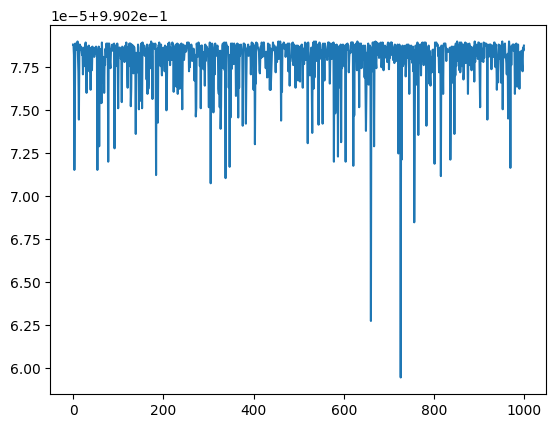

In [15]:
plt.plot(synthetic_data['age'])